<a href="https://colab.research.google.com/github/bdemchak/cytoscape-jupyter/blob/main/gangsu/basic_protocol_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a work-in-progress reproduction of the [Biological Network Exploration with Cytoscape 3](https://pubmed.ncbi.nlm.nih.gov/25199793/) Basic Protocol 2, which imports data from the Goh human disease network and displays it for exploration.


---
#Setup data files, py4cytoscape and Cytoscape connection
---
**NOTE: To run this notebook, you must manually start Cytoscape first -- don't proceed until you have started Cytoscape.**

---
##Setup: Import source data files

For now, the network file is pre-positioned in a sandbox on the workstation. 

It really should be in a web location that gets loaded into the sandbox at run-time. If we could find a way to have a URL directly to this file, we could get get Cytoscape to load it directly via a CyREST POST v1/networks call (assuming we can get Cytoscape itself to load directly from a URL). 

Failing that, there's no reason why this Python script can't load the network into its own file system, then transfer it to the Cytoscape sandbox so Cytoscape can then import it.

The code in this cell actually does load the table data from a URL. This Python script parses the table into a dataframe and then loads the dataframe into Cytoscape. We're going to this trouble because we can't figure out how to get Cytoscape to import a table file using commands_post() ... which means we can't figure out how to create a Command that does this. Once we figure this out, we can pre-position the table data file in the same sandbox as we're using for the network file ... or transfer it to the sandbox early in this Python script.

In [8]:
# !rm GDS112_full.soft BIOGRID-ORGANISM-Saccharomyces_cerevisiae-3.2.105.mitab
# !wget -q --no-check-certificate https://www.dropbox.com/s/8wc8o897tsxewt1/BIOGRID-ORGANISM-Saccharomyces_cerevisiae-3.2.105.mitab?dl=0
# !mv BIOGRID-ORGANISM-Saccharomyces_cerevisiae-3.2.105.mitab?dl=0 BIOGRID-ORGANISM-Saccharomyces_cerevisiae-3.2.105.mitab
# !wget -q --no-check-certificate https://www.dropbox.com/s/r15azh0xb53smu1/GDS112_full.soft?dl=0
# !mv GDS112_full.soft?dl=0 GDS112_full.soft
!rm -r output/
!mkdir output
!ls -l 
OUTPUT_DIR = 'output/'


rm: cannot remove 'output/': No such file or directory
total 12
drwxr-xr-x 2 root root 4096 Dec  5 19:06 logs
drwxr-xr-x 2 root root 4096 Dec  5 19:10 output
drwxr-xr-x 1 root root 4096 Dec  2 22:04 sample_data


---
##Setup: Fetch latest py4cytoscape




**Note that you can fetch from a specific github branch by adding "@<branch>" to the "py4cytocape" at the end of the github URL.**

For example, to get branch 0.0.5: git+https://github.com/cytoscape/py4cytoscape@0.0.5

In [2]:
!pip uninstall -y py4cytoscape

!pip install py4cytoscape
#!pip install git+https://github.com/cytoscape/py4cytoscape@0.0.5
#!pip install git+https://github.com/cytoscape/py4cytoscape

     |████████████████████████████████| 143kB 8.7MB/s 
     |████████████████████████████████| 3.2MB 13.9MB/s 


---
##Setup: Set up Cytoscape connection


In [3]:
import IPython
import py4cytoscape as p4c
print(f'Loading Javascript client ... {p4c.get_browser_client_channel()} on {p4c.get_jupyter_bridge_url()}')
browser_client_js = p4c.get_browser_client_js(True)
IPython.display.Javascript(browser_client_js) # Start browser client


Loading Javascript client ... fefa565f-0c65-4426-9512-66cf16094035 on https://jupyter-bridge.cytoscape.org


<IPython.core.display.Javascript object>

---
#Sanity test to verify Cytoscape connection


In [4]:
p4c.cytoscape_version_info()


{'apiVersion': 'v1',
 'automationAPIVersion': '1.0.0',
 'cytoscapeVersion': '3.8.2',
 'jupyterBridgeVersion': '0.0.2',
 'py4cytoscapeVersion': '0.0.6'}

---
# Set pre-filled sandbox as Cytoscape's current sandbox

This Python script uses just the network (.MITAB) in that sandbox ... the data table is loaded by this script into a dataframe and transferred to Cytoscape directly.

**Sandboxing is explained in https://py4cytoscape.readthedocs.io/en/latest/concepts.html#sandboxing**

In [5]:
gangsu_sandbox = p4c.sandbox_set('GangSu_sandbox', copy_samples=False, reinitialize=False)
gangsu_sandbox

'C:\\Users\\CyDeveloper\\CytoscapeConfiguration\\filetransfer\\GangSu_sandbox'

# Discover local gene clusters using MCODE

##Import the human protein-protein interactions network.

This could take several minutes because of the automatic force-directed layout.

We would prefer to use import_network_from_file, but it doesn't allow any configuration of source/target/interaction/startrow/delimiter. We should fix this.

Note that as long as we're using commands_post, we can't take advantage of the encapsulation provided by sandboxes. Let's try to avoid this.


In [12]:
p4c.close_session(False)
p4c.commands_post(f'network import file file="{gangsu_sandbox}\\Barabasi\\supplementary_tableS4.txt" firstRowAsColumnNames=true startLoadRow=2 indexColumnSourceInteraction=2 indexColumnTargetInteraction=4 indexColumnTypeInteraction=5 columnTypeList="x,s,x,t,i"')


{'networks': [110832], 'views': [140390]}

##Layout and overlay information on the network

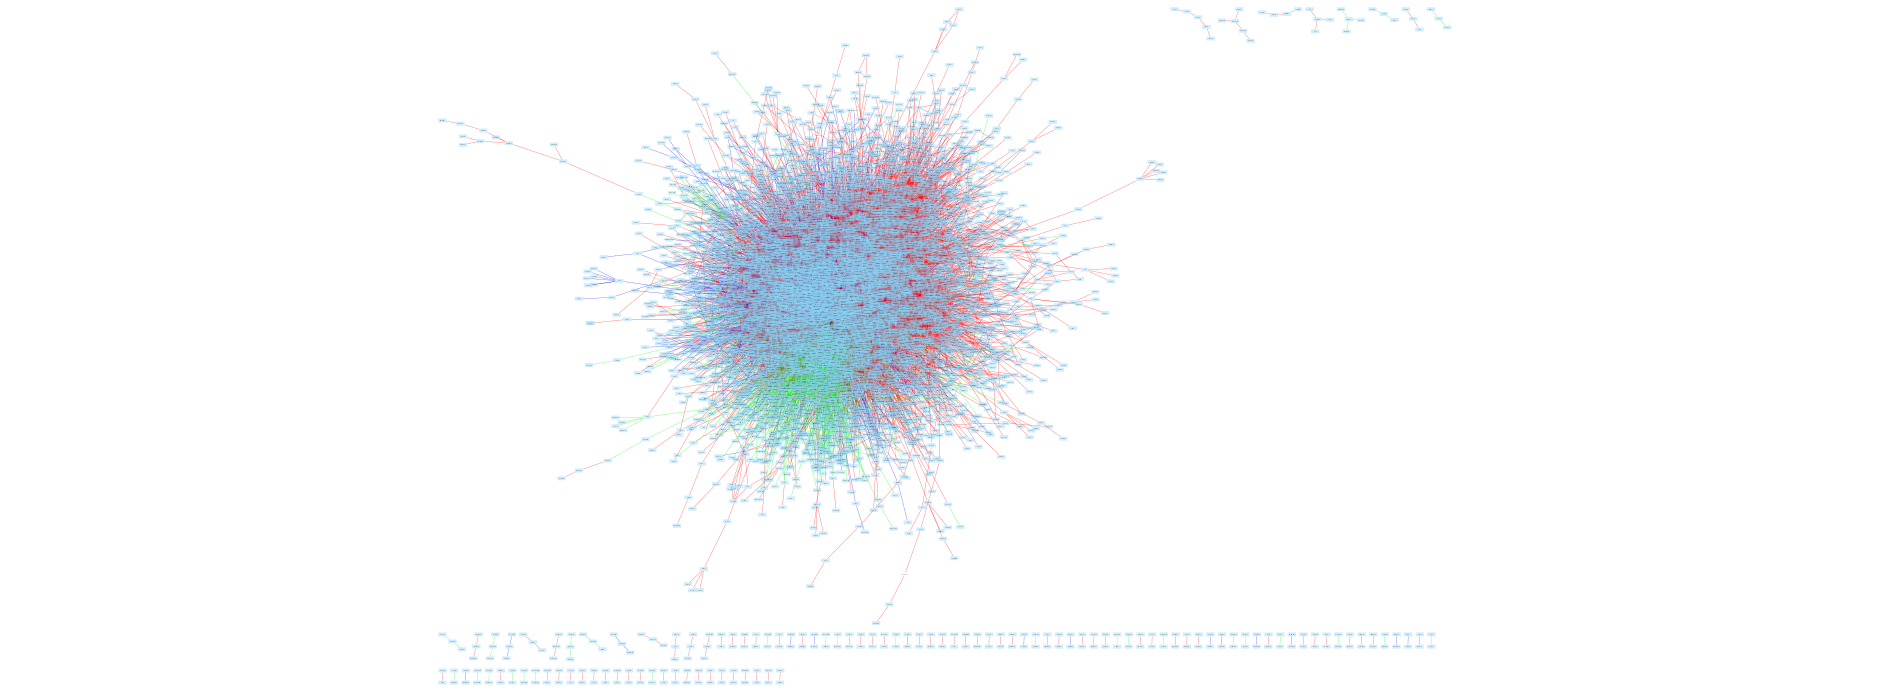

In [13]:
map = p4c.map_visual_property('EDGE_STROKE_UNSELECTED_PAINT', 'interaction', 'discrete', ['L', 'R', 'RL', 'RS', 'RSL', 'S', 'SL'], ['#ff0000', '#00ff00', '#00ffff', '#ff00ff', '#ffff00', '#0000ff', '#808080'])
p4c.update_style_mapping('default', map)
p4c.set_node_fill_opacity_default(100, 'default')
p4c.toggle_graphics_details()
p4c.export_image('WholeNetwork.png')
p4c.sandbox_get_from('WholeNetwork.png', f'{OUTPUT_DIR}WholeNetwork.png')

from IPython.display import Image, display
display(Image(filename=f'{OUTPUT_DIR}WholeNetwork.png'))

{}


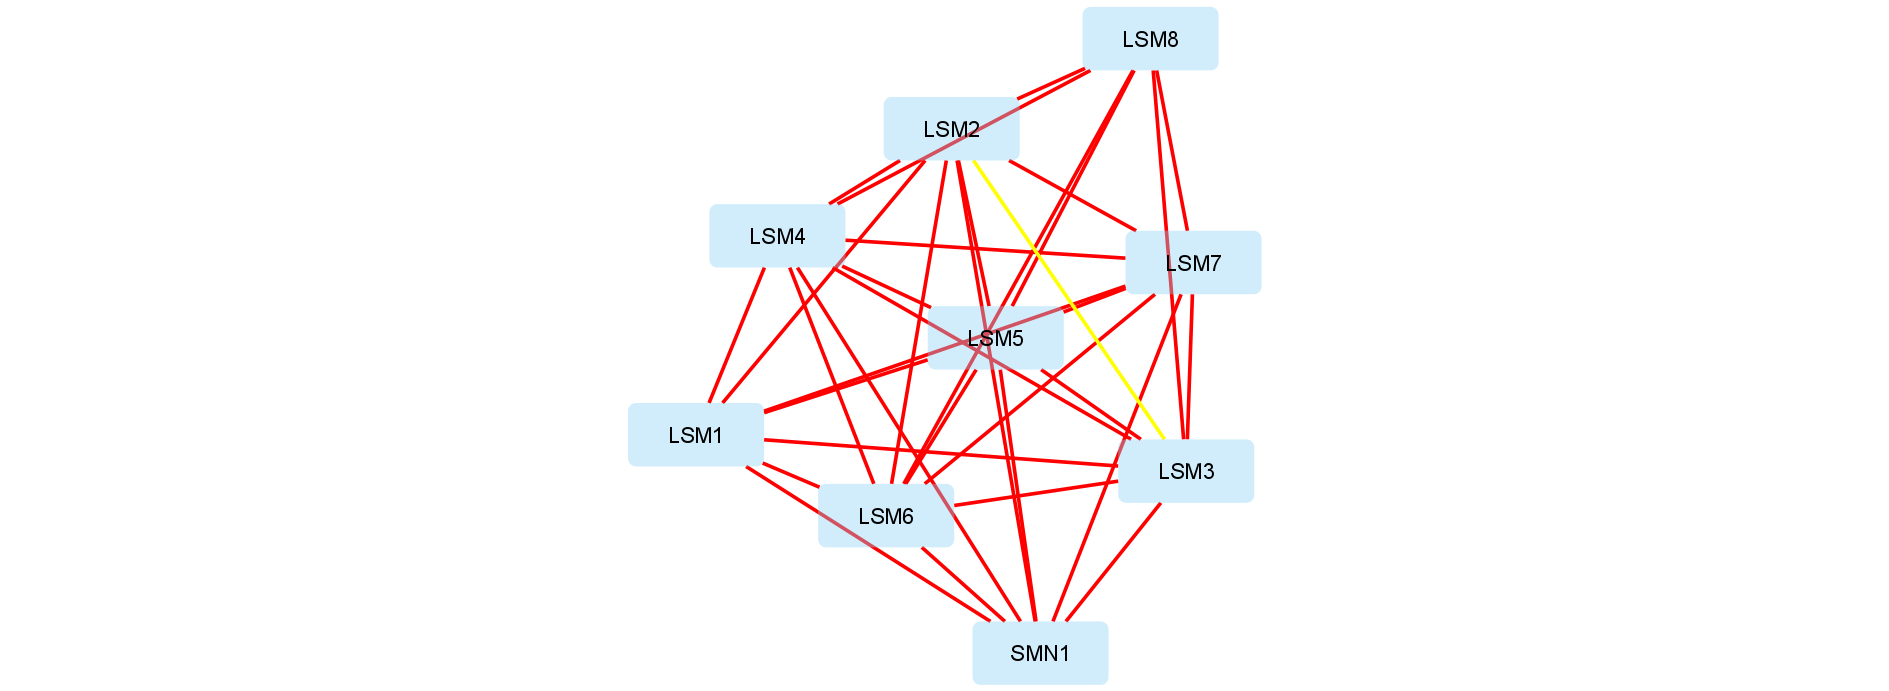

In [14]:
p4c.install_app('MCODE')
p4c.commands_post('mcode cluster network=""')
p4c.commands.commands_post('mcode view id=1 rank=2')
p4c.export_image('Cluster.png')
p4c.sandbox_get_from('Cluster.png', f'{OUTPUT_DIR}Cluster.png')

from IPython.display import Image, display
display(Image(filename=f'{OUTPUT_DIR}Cluster.png'))

# Load the s. cerevisiae MITAB network into Cytoscape

Note that the import_network_from_file function (incorrectly) throws an exception, so we explicitly ignore the exception.

In [ ]:
from requests import HTTPError
p4c.close_session(False)

try:
  p4c.import_network_from_file('BIOGRID-ORGANISM-Saccharomyces_cerevisiae-3.2.105.mitab')
except:  
  pass
if p4c.get_network_count() != 1:
  raise Exception('Failed to load network')
net_suid = p4c.get_network_suid()
net_suid



In commands_post(): {'status': 500, 'type': 'urn:cytoscape:ci:cyrest-core:v1:handle-json-command:errors:3', 'message': 'Task returned invalid json.', 'link': 'file:/C:/Users/CyDeveloper/CytoscapeConfiguration/3/framework-cytoscape.log'}


1711653

# Get the gene expression data into a data frame

Explicitly set the Gene ID as a string even though it's originally parsed as a number. To Cytoscape, the string will be compatible the 'name' column already in the BIOGRID network.

ToDo:
1) Consider how to use read_csv to force Gene ID to string ... see here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html ... dtype parameter
2) Consider how to use read_csv to avoid having to do wget in the first place
3) Better yet, get Cytoscape to import the data table directly.

In [ ]:
import pandas as df
GDS112_full = df.read_csv('GDS112_full.soft', skiprows=82, sep='\t')
GDS112_full.dropna(subset=['Gene ID'], inplace=True)
GDS112_full['Gene ID'] = df.to_numeric(GDS112_full['Gene ID'], downcast='integer')
GDS112_full = GDS112_full.astype({'Gene ID': 'string'})
print(GDS112_full.dtypes)


GDS112_full



ID_REF                    object
IDENTIFIER                object
GSM1029                  float64
GSM1030                  float64
GSM1032                  float64
GSM1033                  float64
GSM1034                  float64
Gene title                object
Gene symbol               object
Gene ID                   string
UniGene title            float64
UniGene symbol           float64
UniGene ID               float64
Nucleotide Title         float64
GI                       float64
GenBank Accession        float64
Platform_CLONEID         float64
Platform_ORF              object
Platform_SPOTID           object
Chromosome location      float64
Chromosome annotation     object
GO:Function               object
GO:Process                object
GO:Component              object
GO:Function ID            object
GO:Process ID             object
GO:Component ID           object
dtype: object


,ID_REF,IDENTIFIER,GSM1029,GSM1030,GSM1032,GSM1033,GSM1034,Gene title,Gene symbol,Gene ID,UniGene title,UniGene symbol,UniGene ID,Nucleotide Title,GI,GenBank Accession,Platform_CLONEID,Platform_ORF,Platform_SPOTID,Chromosome location,Chromosome annotation,GO:Function,GO:Process,GO:Component,GO:Function ID,GO:Process ID,GO:Component ID
24,25,TFC3,-0.663,0.144,0.605,0.696,0.659,transcription factor TFIIIC subunit TFC3,TFC3,851262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YAL001C,NaN,NaN,"Chromosome I, NC_001133.9 (147594..151166, com...","DNA binding///contributes_to DNA binding, bend...",5S class rRNA transcription from RNA polymeras...,mitochondrion///mitochondrion///colocalizes_wi...,GO:0003677///contributes_to GO:0008301///contr...,GO:0042791///GO:0042791///GO:0071168///GO:0006...,GO:0005739///GO:0005739///colocalizes_with GO:...
25,26,EFB1,0.678,0.343,0.844,-0.072,-0.084,translation elongation factor 1 subunit beta,EFB1,851260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YAL003W,NaN,NaN,"Chromosome I, NC_001133.9 (142174..143160)",guanyl-nucleotide exchange factor activity///t...,maintenance of translational fidelity///negati...,eukaryotic translation elongation factor 1 com...,GO:0005085///GO:0003746,GO:1990145///GO:0032232///GO:0006449///GO:0006...,GO:0005853///GO:0005853
26,27,SSA1,-0.956,-0.026,1.441,0.854,0.025,Hsp70 family ATPase SSA1,SSA1,851259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YAL005C,NaN,NaN,"Chromosome I, NC_001133.9 (139503..141431, com...",ATP binding///ATPase activity///nucleotide bin...,SRP-dependent cotranslational protein targetin...,cell wall///colocalizes_with chaperonin-contai...,GO:0005524///GO:0016887///GO:0000166///GO:0000...,GO:0006616///GO:0072318///GO:0002181///GO:0043...,GO:0005618///colocalizes_with GO:0005832///GO:...
27,28,FUN14,-0.435,-0.247,0.662,0.688,0.192,Fun14p,FUN14,851225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YAL008W,NaN,NaN,"Chromosome I, NC_001133.9 (136914..137510)",molecular_function,mitochondrion organization///phospholipid home...,integral component of membrane///integral comp...,GO:0003674,GO:0007005///GO:0055091,GO:0016021///GO:0031307///GO:0016020///GO:0005...
28,29,MDM10,-0.505,0.169,0.823,0.457,0.208,Mdm10p,MDM10,851223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YAL010C,NaN,NaN,"Chromosome I, NC_001133.9 (134184..135665, com...",molecular_function,establishment of mitochondrion localization///...,ERMES complex///ERMES complex///integral compo...,GO:0003674,GO:0051654///GO:0000002///GO:0070096///GO:0070...,GO:0032865///GO:0032865///GO:0016021///GO:0031...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9201,9202,VMA13,0.162,-0.202,0.649,0.132,0.042,H(+)-transporting V1 sector ATPase subunit H,VMA13,856148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YPR036W,NaN,NaN,"Chromosome XVI, NC_001148.4 (643836..645272)","hydrolase activity, acting on acid anhydrides,...",ATP hydrolysis coupled proton transport///ion ...,fungal-type vacuole membrane///integral compon...,GO:0016820///GO:0046961///GO:0046961,GO:0015991///GO:0006811///GO:0015992///GO:0006...,GO:0000329///GO:0016021///GO:0016020///GO:0005...
9203,9204,TIP41,0.084,-0.088,0.262,0.118,0.039,Tip41p,TIP41,856153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YPR040W,NaN,NaN,"Chromosome XVI, NC_001148.4 (647305..648375)",molecular_function,negative regulation of signal transduction///s...,cytoplasm///cytoplasm///nucleus///nucleus,GO:0003674,GO:0009968///GO:0007165///GO:0007165,GO:0005737///GO:0005737///GO:0005634///GO:0005634
9205,9206,ANT1,0.163,-0.314,0.011,0.350,0.472,Ant1p,ANT1,856246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YPR128C,NaN,NaN,"Chromosome XVI, NC_001148.4 (791218..792204, c...",adenine nucleotide transmembrane transporter a...,ATP transport///fatty acid beta-oxidation///fa...,cytoplasm///integral component of membrane///i...,GO:0000295///GO:0000295,GO:0015867///GO:0006635///GO:0006635///GO:0006...,GO:0005737///GO:0016021///GO:0016021///GO:0005...
9207,9208,RPS23B,0.849,0.124,-0.872,-1.023,-0.432,ribosomal 40S subunit protein S23B,RPS23B,856250,NaN,NaN,NaN,Na

# Load the dataframe into Cytoscape's node table

The Gene ID column in the dataframe is matched to the network's name column

In [ ]:
p4c.load_table_data(GDS112_full, data_key_column='Gene ID')

/usr/local/lib/python3.6/dist-packages/py4cytoscape/tables.py:408: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[col] = col_val


'Success: Data loaded in defaultnode table'

# Create a filter to remove nodes having no Gene Symbol

In [ ]:
p4c.create_column_filter('SymbolOK', 'Gene symbol', '[A-Z0-9]*', 'REGEX')

No nodes selected.
No edges selected.


{'edges': None, 'nodes': None}

# Execute the filter to select all named nodes

The filter should have been applied at creation time, but there appears to be a bug in Cytoscape where the "Apply" checkbox is turned off when a network is imported. So, we do this explicitly here instead.

In [ ]:
p4c.apply_filter('SymbolOK')

No edges selected.


{'edges': None,
 'nodes': ['854886',
  '854222',
  '851076',
  '851709',
  '850972',
  '856438',
  '854475',
  '855594',
  '856389',
  '850903',
  '850330',
  '856167',
  '856923',
  '850884',
  '851975',
  '853789',
  '855264',
  '852719',
  '853743',
  '851721',
  '850352',
  '853631',
  '850892',
  '854856',
  '851334',
  '850847',
  '856057',
  '851396',
  '856914',
  '855135',
  '851218',
  '852426',
  '851484',
  '853732',
  '851500',
  '854702',
  '854545',
  '855241',
  '854747',
  '851422',
  '855321',
  '851247',
  '855150',
  '855415',
  '851344',
  '853487',
  '853858',
  '854744',
  '852482',
  '856239',
  '854981',
  '854310',
  '852062',
  '855936',
  '854667',
  '855336',
  '851066',
  '850875',
  '855498',
  '850706',
  '853274',
  '854050',
  '851445',
  '851953',
  '852323',
  '856811',
  '854693',
  '855783',
  '856487',
  '856797',
  '855531',
  '850453',
  '851724',
  '856554',
  '855238',
  '856595',
  '850832',
  '853377',
  '856081',
  '854659',
  '856734',
  '

# Create a subnetwork containing only named nodes

This could take several minutes

In [ ]:
new_suid = p4c.create_subnetwork()
new_suid

2057179

# Get rid of the original network, which isn't needed anymore

In [ ]:
p4c.delete_network(net_suid)
net_suid = new_suid

# Layout the subnetwork in case it wasn't already

In [ ]:
p4c.layout_network('force-directed')


{}

# Install clusterMaker2 if it hasn't already been installed

In [ ]:
p4c.install_app('clusterMaker2')

{}


{}

# Create the hierarchical clustering and dendogram

This returns a large data structure that describes the dendogram.

It also creates a dendogram window that's designed for GUI manipulation. It's unclear this can be controlled or used by automation calls.

In [ ]:
p4c.commands_post('cluster hierarchical showUI=true clusterAttributes=false nodeAttributeList="GSM1029,GSM1030,GSM1032,GSM1033,GSM1034"')

[{'nodeOrder': [{'nodeName': '850532', 'suid': 1719138},
   {'nodeName': '852226', 'suid': 1735466},
   {'nodeName': '852238', 'suid': 1725292},
   {'nodeName': '850872', 'suid': 1711800},
   {'nodeName': '850893', 'suid': 1713224},
   {'nodeName': '854381', 'suid': 1712108},
   {'nodeName': '855591', 'suid': 1714403},
   {'nodeName': '851208', 'suid': 1711930},
   {'nodeName': '852107', 'suid': 1713570},
   {'nodeName': '852854', 'suid': 1823370},
   {'nodeName': '850695', 'suid': 1712610},
   {'nodeName': '851125', 'suid': 1712550},
   {'nodeName': '850422', 'suid': 1712553},
   {'nodeName': '852549', 'suid': 1714392},
   {'nodeName': '851366', 'suid': 1730408},
   {'nodeName': '854469', 'suid': 1735638},
   {'nodeName': '852704', 'suid': 1716090},
   {'nodeName': '853534', 'suid': 1719035},
   {'nodeName': '850820', 'suid': 1712551},
   {'nodeName': '855473', 'suid': 1712947},
   {'nodeName': '853762', 'suid': 1716109},
   {'nodeName': '853682', 'suid': 1711924},
   {'nodeName': '85

#Use BiNGO for enrichment analysis

The BiNGO app doesn't have automation entrypoints, so this analysis isn't possible right now. Is there a different app that can do this?